In [1]:
#2D isothermal cylindrical SS and just SMR
#I think we should still convert it to molar flowrates somehow!!!

from scipy.integrate import solve_bvp, solve_ivp, odeint
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#reactor constants
L = 0.0609 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m

h2Removal = 0 #change to 1 if there is removal of hydrogen

#gas flow constants
T = 622+273 #K
P = 1 #bar or atm

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 * 60
y0 = mols0/sum(mols0)
print(y0)
Ctot = P/(8.3144598 * 10**-5 * T)

u0 = sum(sccm0) * 273 / T * P / 1 / 60 #cm^3/sec
A = np.pi * ((R_outer*100)**2-(R_inner*100)**2) #cm^2 MIGHT HAVE TO ADJUST THE AREA CALC A BIT
v0 = u0 / A / 100 #m/sec

#rate equation constants
Rgas = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

I = 9 #curent in Amps
F = 96485 #faradays constant
Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
Keqwgs = np.exp(4400/T - 4.036)

[0.20291311 0.60873933 0.         0.         0.12556504 0.06278252]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0

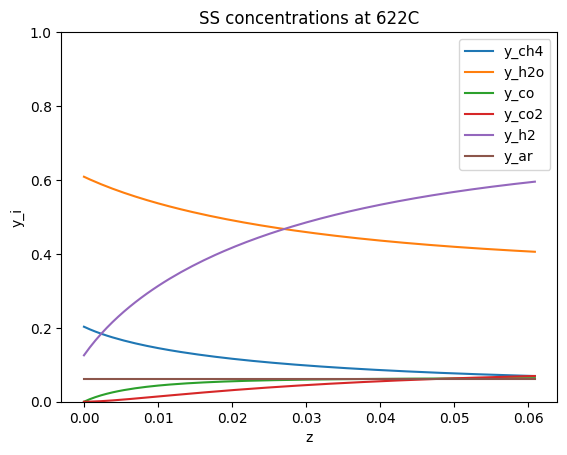

In [3]:
#solving the ODE system first IT WOULD WORK WITH ODE SYSTEM BUT WHEN GOING TO PDE IT WOULD JUST BE A MORE SOPHISTICATED IVP SOLVER WITH DISCRITIZATION

#CURRENTLY I AM IGNORING ARGON BECAUSE I WAS HAVING ERRORS
x_num = 80

x_pts = np.linspace(0,L,x_num)

#initial guess array
init_guess = np.zeros((6, x_num))

# init_guess[0, :] = 0.2
# init_guess[1, :] = 0.6  
# init_guess[2, :] = 0
# init_guess[3, :] = 0    
# init_guess[4, :] = 0.1

#what seems to me to be better guesses makes it worse

def odes(x, y): #dy/dt = f(x)
    #NEED TO ADJUST THIS. THESE ARE NOT CONCENTRATIONS, THEY ARE MOL FRACTIONS
    Cch4 = y[0]
    Ch2o = y[1]
    Cco = y[2]
    Cco2 = y[3]
    Ch2 = y[4]
    
    v = v0*(3*y0[0] - 2*Cch4)/y0[0] # v0*(1+2X)
    # print(len(v))

    rsmr = 2/R_outer*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(Cch4*Ch2o-(P**2)*Cco*(Ch2**3)/Keqsmr)/Ctot
    rwgs = 2/R_outer*Ku*Awgs*np.exp(-Eawgs*1000/Rgas/T)*(Ch2o*Cco-Cco2*Ch2/Keqwgs)/Ctot
    rh2r = I/(2*F*L)/Ctot #have not confirmed if this is correct
    print(rsmr)

    ch4 = (-rsmr)/v
    h2o = (-rsmr - rwgs)/v
    co = (rsmr - rwgs)/v
    co2 = (rwgs)/v
    h2 = (3*rsmr + rwgs + h2Removal*rh2r)/v
    ar = np.zeros(len(Cch4))
    
    return np.vstack([ch4, h2o, co, co2, h2, ar])

def bcs(yleft, yright):
    return np.array(yleft-y0)

soln = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=200) #look into using odeint. the ODEs are still. use the adam solver

plt.plot(soln.x, soln.y[0], label='y_ch4')
plt.plot(soln.x, soln.y[1], label='y_h2o')
plt.plot(soln.x, soln.y[2], label='y_co')
plt.plot(soln.x, soln.y[3], label='y_co2')
plt.plot(soln.x, soln.y[4], label='y_h2')
plt.plot(soln.x, soln.y[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z')
plt.ylabel('y_i')
plt.title('SS concentrations at ' + str(T-273) + 'C')
plt.legend()


       message: The algorithm converged to the desired accuracy.
       success: True
        status: 0
             x: [ 0.000e+00  7.709e-04 ...  6.013e-02  6.090e-02]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x0000018F9A218350>
             p: None
             y: [[ 1.000e+00  1.000e+00 ...  1.002e+00  1.002e+00]]
            yp: [[ 0.000e+00  7.709e-04 ...  6.013e-02  6.090e-02]]
 rms_residuals: [ 1.250e-13  5.949e-14 ...  1.246e-13  6.331e-14]
         niter: 1


C:\Users\Alexa\AppData\Local\Temp\ipykernel_7324\2066845197.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


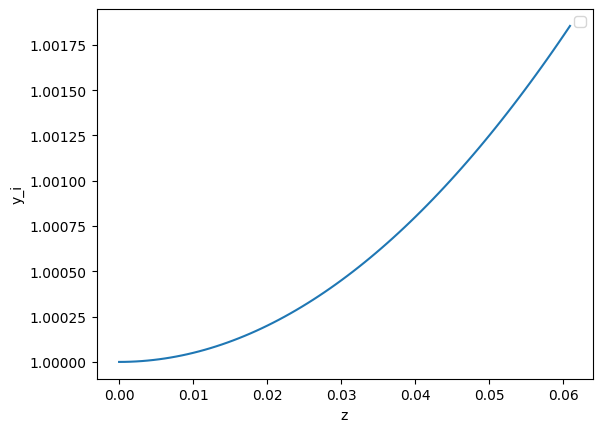

In [4]:
#testing solve bvp
#dydx = y

def testode(y,x):
    return np.array([y])

def testbc(ya, yb):
    return np.array([ya[0] - 1])

testsoln = solve_bvp(testode, testbc, x_pts, np.zeros((1,len(x_pts))))
print(testsoln)
plt.plot(testsoln.x, testsoln.y[0])
plt.xlabel('z')
plt.ylabel('y_i')
plt.legend()

[[ 2.02913109e-01  6.08739327e-01  0.00000000e+00  0.00000000e+00
   1.25565043e-01]
 [-4.41974079e+03  9.26679307e+03  1.81060717e+04 -1.36861280e+04
  -4.26171364e+02]
 [ 2.91200000e+03  0.00000000e+00  3.58400000e+03  0.00000000e+00
   4.16800000e+03]
 [ 0.00000000e+00  4.82400000e+03  0.00000000e+00  5.49600000e+03
   0.00000000e+00]
 [ 5.91200000e+03  0.00000000e+00  6.35200000e+03  0.00000000e+00
   7.00000000e+03]
 [ 0.00000000e+00  7.41600000e+03  0.00000000e+00  7.71200000e+03
   0.00000000e+00]
 [ 8.36000000e+03  0.00000000e+00  9.03200000e+03  0.00000000e+00
   9.59200000e+03]
 [ 0.00000000e+00  9.92800000e+03  0.00000000e+00  1.05760000e+04
   0.00000000e+00]
 [ 1.09920000e+04  0.00000000e+00  1.13280000e+04  0.00000000e+00
   1.20000000e+04]
 [ 0.00000000e+00  1.26800000e+04  0.00000000e+00  1.33600000e+04
   0.00000000e+00]]


C:\Users\Alexa\AppData\Local\Temp\ipykernel_7324\1411701075.py:31: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  soln = odeint(odes, y0[:5], x_pts, h0=0.0000000001, hmax=0.000001) #look into using odeint. the ODEs are still. use the adam solver


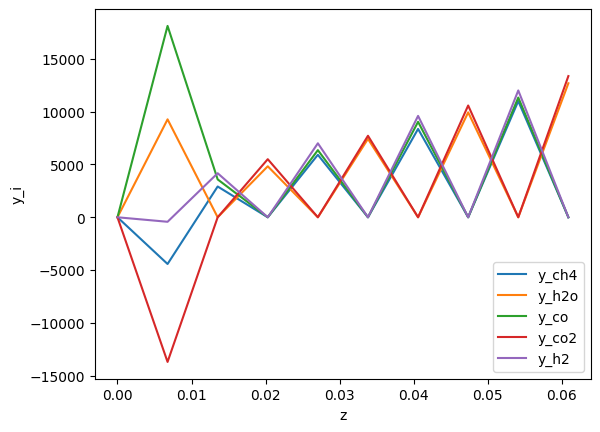

In [5]:
#TROUBLE SHOOTING

x_num = 100

x_pts = np.linspace(0,L,10)

def odes(y, t): #dy/dt = f(x)
    #NEED TO ADJUST THIS. THESE ARE NOT CONCENTRATIONS, THEY ARE MOL FRACTIONS
    Cch4 = y[0]
    Ch2o = y[1]
    Cco = y[2]
    Cco2 = y[3]
    Ch2 = y[4]  

    # v = v0*(3*y0[1] - 2*Cch4)/y0[1] # v0*(1+2X)
    v = v0
    # print(v)

    rsmr = 2/R_outer*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(Cch4*Ch2o-(P**2)*Cco*(Ch2**3)/Keqsmr)/Ctot
    rwgs = 2/R_outer*Ku*Asmr*np.exp(-Eawgs*1000/Rgas/T)*(Ch2o*Cco2-Cco*Ch2/Keqwgs)/Ctot
    rh2r = I/(2*F*L)/Ctot #have not confirmed if this is correct
    # print(rsmr)

    ch4 = (-rsmr)/v
    h2o = (-rsmr - rwgs)/v
    co = (rsmr - rwgs)/v
    co2 = (rwgs)/v
    h2 = (3*rsmr + rwgs + h2Removal*rh2r)/v
    return ch4, h2o, co, co2, h2

soln = odeint(odes, y0[:5], x_pts, h0=0.0000000001, hmax=0.000001) #look into using odeint. the ODEs are still. use the adam solver
print(soln)

plt.plot(x_pts, soln[:,0], label='y_ch4')
plt.plot(x_pts, soln[:,1], label='y_h2o')
plt.plot(x_pts, soln[:,2], label='y_co')
plt.plot(x_pts, soln[:,3], label='y_co2')
plt.plot(x_pts, soln[:,4], label='y_h2')
# plt.ylim(0, 1)
plt.xlabel('z')
plt.ylabel('y_i')
plt.legend()